In [1]:
import tensorflow as tf
import numpy as np
import os
from pathlib import Path

# 1) Montar Google Drive (si el modelo está ahí)
from google.colab import drive
drive.mount('/content/drive')

# 2) Ruta al modelo guardado (ajústala a donde lo tengas)
MODEL_PATH = "/content/drive/MyDrive/models/best_model_SN.h5"  # 🔁 CAMBIA ESTA RUTA

# 3) Cargar el modelo
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()


Mounted at /content/drive


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,728 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [2]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']


In [3]:
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf

IMG_SIZE = (96, 96)

def load_and_preprocess_image(img_path, img_size=IMG_SIZE):
    """
    Carga una imagen desde img_path, la convierte a escala de grises,
    la redimensiona a img_size y la adapta a la entrada del modelo.
    """
    # 1) Cargar en escala de grises y redimensionar
    img = load_img(img_path, color_mode='grayscale', target_size=img_size)

    # 2) Convertir a arreglo numpy (96,96,1)
    img_array = img_to_array(img)

    # 3) Convertir a tensor de TensorFlow
    img_tensor = tf.convert_to_tensor(img_array)

    # 4) Convertir de gris (1 canal) a RGB (3 canales)
    img_tensor = tf.image.grayscale_to_rgb(img_tensor)  # (96,96,3)

    # 5) Añadir dimensión batch: (1,96,96,3)
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    # El modelo ya tiene layers.Rescaling(1./255)
    return img_tensor


In [4]:
def predict_emotion(img_path):
    # Preprocesar la imagen
    img_batch = load_and_preprocess_image(img_path)

    # Hacer la predicción
    preds = model.predict(img_batch, verbose=0)  # shape: (1, n_classes)

    # Índice de la clase con mayor probabilidad
    pred_idx = int(tf.argmax(preds, axis=1).numpy()[0])

    # Probabilidad de la clase predicha
    pred_prob = float(tf.reduce_max(preds).numpy())

    # Nombre de la emoción
    pred_class = class_names[pred_idx]

    return pred_class, pred_prob, preds[0]


In [12]:
test_image_path = "/content/triste2.JPG"  # 🔁 pon aquí tu imagen

pred_class, pred_prob, pred_vector = predict_emotion(test_image_path)

print(f"Emoción predicha: {pred_class}")
print(f"Confianza: {pred_prob*100:.2f}%")
print("Vector de probabilidades:", pred_vector)

# ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']


Emoción predicha: sad
Confianza: 94.42%
Vector de probabilidades: [0.00540191 0.00293535 0.00149478 0.03421355 0.9441883  0.01176612]


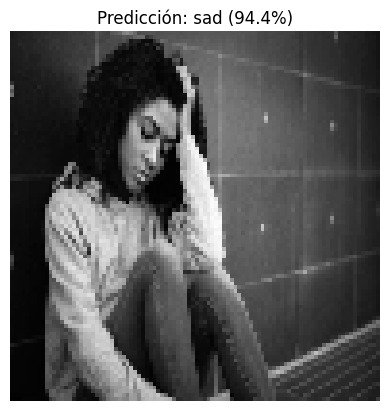

In [13]:
import matplotlib.pyplot as plt

img = load_img(test_image_path, color_mode='grayscale', target_size=IMG_SIZE)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f"Predicción: {pred_class} ({pred_prob*100:.1f}%)")
plt.show()
